In [15]:
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd

# I. Overview of Malaysia Map

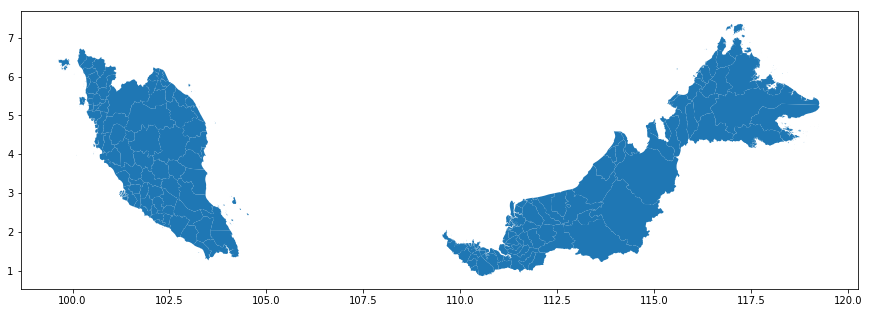

In [17]:
malaysia_map = gpd.read_file(shp_path)
fig, ax = plt.subplots(figsize=(15, 15))
malaysia_map.plot(ax=ax)

# II. Load Malaysia Shapefile

In [2]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column
    holding the geometry information. This uses the pyshp package.
    """
    fields = [x[0] for x in sf.fields][1:]
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
    
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    
    return df

In [6]:
shp_path = "/Users/shenghao/Desktop/shenghao-repos/asiatique/MYS_adm/MYS_adm2.shp"
sf = shp.Reader(shp_path)
shp_df = read_shapefile(sf)
print(shp_df.shape)
print("States of Malaysia: ", set(shp_df["NAME_1"]))
shp_df.head()

(160, 12)
States of Malaysia:  {'Sarawak', 'Sabah', 'Selangor', 'Perak', 'Trengganu', 'Kedah', 'Melaka', 'Pulau Pinang', 'Perlis', 'Kelantan', 'Negeri Sembilan', 'Johor', 'Pahang'}


,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,coords
0,136,MYS,Malaysia,1,Johor,1,Batu Pahat,District,District,,,"[(102.91184997558594, 1.7636120319367024), (10..."
1,136,MYS,Malaysia,1,Johor,2,Johor Baharu,District,District,,Johor Bahru,"[(103.55655670166016, 1.455448031425533), (103..."
2,136,MYS,Malaysia,1,Johor,3,Keluang,District,District,,,"[(103.10678100585938, 2.1662011146546547), (10..."
3,136,MYS,Malaysia,1,Johor,4,Kota Tinggi,District,District,,,"[(104.05722045898438, 1.5308330059052082), (10..."
4,136,MYS,Malaysia,1,Johor,5,Mersing,District,District,,,"[(104.09871673583996, 2.931370973587093), (104..."


In [28]:
penang_df = shp_df.loc[shp_df["NAME_1"] == "Pulau Pinang"]
print(penang_df.shape)
penang_df.head()

(5, 12)


,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,coords
60,136,MYS,Malaysia,9,Pulau Pinang,61,Barat Daya,District,District,,,"[(100.23988342285156, 5.468217849731502), (100..."
61,136,MYS,Malaysia,9,Pulau Pinang,62,Seberang Perai Selatan,District,District,,Daerah Selatan,"[(100.50340270996105, 5.147298812866268), (100..."
62,136,MYS,Malaysia,9,Pulau Pinang,63,Seberang Perai Tengah,District,District,,Daerah Tengah,"[(100.53479766845709, 5.28922080993658), (100...."
63,136,MYS,Malaysia,9,Pulau Pinang,64,Seberang Perai Utara,District,District,,Daerah Utara,"[(100.37730407714855, 5.3895778656007), (100.3..."
64,136,MYS,Malaysia,9,Pulau Pinang,65,Timur Laut,District,District,,,"[(100.23988342285156, 5.468217849731502), (100..."


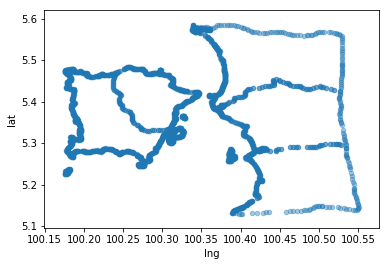

In [29]:
penang_coords = []
for coords in penang_df.loc[:, 'coords'].values:
    penang_coords.extend(coords)
df = pd.DataFrame(penang_coords, columns=['lng', 'lat'])
df.plot(kind="scatter", x="lng", y="lat", alpha=0.4)
plt.show()

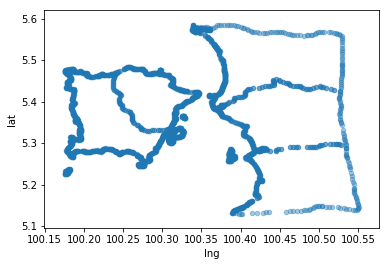

In [26]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(population), s=area,
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');